In [136]:
import sys, os, csv, datetime
from typing import Dict
parent_directory = os.path.split(os.getcwd())[0]
src_directory = os.path.join(parent_directory, 'src')
data_directory = os.path.join(parent_directory, 'data')
ephemeris_data_directory = os.path.join(data_directory, 'ephemeris')
sys.path.insert(0, src_directory)

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import hydra
from omegaconf import DictConfig, OmegaConf

import gnss_lib.coordinates as coord
import gnss_lib.read_nmea as nmea
import gnss_lib.utils as utils 
import gnss_lib.solve_pos as solve_pos
from correction_network.set_transformer_reduction import SetTransformerPointOutput
from simple_problems.topkitems import KTopItemsDataset
from simple_problems.maxitems import MaxItemsDataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
net = SetTransformerPointOutput(5, 1, 1, dim_hidden=16, num_heads=1, batch_first=True)

In [138]:
tmp_dataset = MaxItemsDataset()
train_dataloader = DataLoader(tmp_dataset, batch_size=1, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [139]:
tmp_in, tmp_lab, tmp_mask = tmp_dataset[10]
tmp_out = net(tmp_in.unsqueeze(0), tmp_mask.unsqueeze(0))
tmp_out.squeeze(), tmp_lab
# tmp_in, tmp_lab, tmp_mask, tmp_out

(tensor(0.0986, grad_fn=<SqueezeBackward0>), tensor(0.9000))

In [146]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, mask = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs, mask)
        loss = criterion(outputs.squeeze(-1), labels) # .reshape(-1, 1).expand(outputs.shape[:-1])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 1:    # print every k mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     2] loss: 0.000
[2,     2] loss: 0.000
[3,     2] loss: 0.000
[4,     2] loss: 0.000
[5,     2] loss: 0.000
[6,     2] loss: 0.000
[7,     2] loss: 0.000
[8,     2] loss: 0.000
[9,     2] loss: 0.000
[10,     2] loss: 0.000
[11,     2] loss: 0.000
[12,     2] loss: 0.000
[13,     2] loss: 0.000
[14,     2] loss: 0.000
[15,     2] loss: 0.000
[16,     2] loss: 0.000
[17,     2] loss: 0.000
[18,     2] loss: 0.000
[19,     2] loss: 0.000
[20,     2] loss: 0.000
Finished Training


In [147]:
def gen_error_traj(net, dataset):
    item_to_idx = {np.array2string(dataset.items[i].numpy()) : i for i in range(dataset.max_items)}
    all_inputs = torch.zeros(len(dataset), dataset.max_items)
    all_labels = torch.zeros(len(dataset))
    all_outputs = torch.zeros(len(dataset))
    for i, (inputs, labels, mask) in enumerate(dataset):
        outputs = net(inputs.unsqueeze(0), mask.unsqueeze(0)).squeeze().detach()
        for j, tmp_in in enumerate(inputs):
            if not mask[j]:
                tmp_idx = item_to_idx[np.array2string(tmp_in.numpy())]
                all_inputs[i, tmp_idx] = 1.0
        all_labels[i] = labels
        all_outputs[i] = outputs
    
    plt.figure(figsize=(20, 15), dpi=80)
    plt.imshow(all_inputs.T)
    plt.figure(figsize=(20, 5), dpi=80)
    plt.plot(all_labels)
    plt.plot(all_outputs)

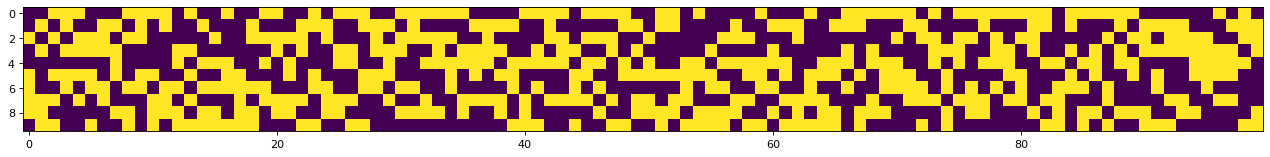

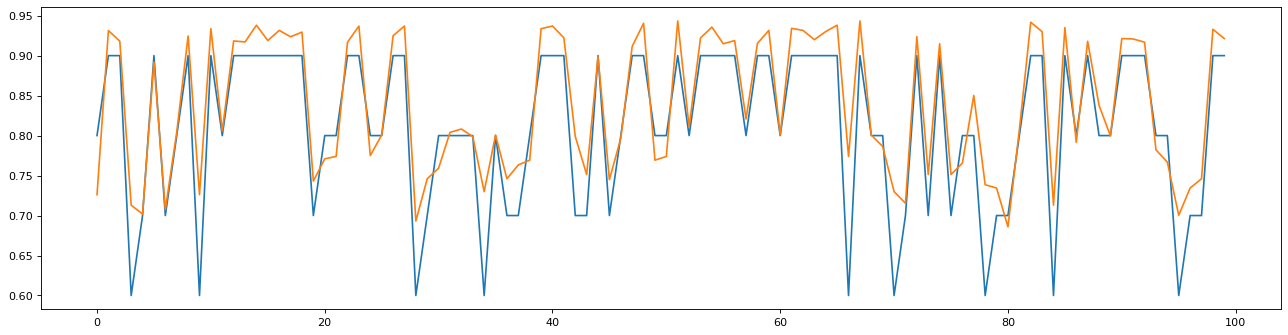

In [148]:
gen_error_traj(net, tmp_dataset)